In [1]:
import numpy as np
import math
from typing import *
import matplotlib.pyplot as plt

# Zadanie 3
W zadaniu tym zajmiemy się omawianym na wykładzie ukrytym łańcuchem Markowa, <br>
na przykładzie nieuczciwego krupiera rzucającego kością. <br>
Przypominam zasady:
1. Krupier ma dwie kości, uczciwą i oszukaną.
2. Kość oszukana daje 6 oczek z $p=\frac{1}{2}$, a pozostałe wyniki z $p=\frac{1}{10}$
3. Krupier zmienia kość uczciwą na nieuczciwą z $p1 = 0.04$, a nieuczciwą na uczciwą z $p2 = 0.05$
4. Zaczynamy od uczciwej kości.
Napisz program, który dla danego ciągu rzutów (który musisz sam wygenerować) wypisuje ciąg stanów (u – kość uczciwa, n – kość nieuczciwa, długość rzędu 10000), <br>
w sposób maksymalizujący liczbę prawidłowo zgadniętych stanów. <br>
Rozwiąż to zadanie na dwa sposoby:
* Proponując heurystyczny algorytm decydujący na podstawie badania skupisk szóstek
* Implementując poprawny algorytm, bazujący na zmiennych α oraz β (zobacz wykład o HMM).

Wykonując eksperymenty, oszacuj poprawność działania obu algorytmów, mierzoną liczbą poprawnie zgadniętych stanów (podzieloną przez długość ciągu).

In [2]:
p0, p1 = 0.04, 0.05

loaded_6 = 0.5
loaded_rest = 0.1

In [3]:
def generate_sequence(
    N: int = 10000,
    p0: float = p0, p1: float = p1,
    loaded_6: float = loaded_6, loaded_rest: float = loaded_rest,
) -> np.ndarray:
    assert abs(loaded_6 + loaded_6 - 1) < 1e-9
    throws_sequence, which_dice = [], []
    act_dice = 0  # 0 - fair, 1 - loaded
    for i in range(N):
        which_dice.append(act_dice)
        r = np.random.rand()
        if act_dice == 0:
            dice_throw = np.random.choice([1, 2, 3, 4, 5, 6], p=[1 / 6] * 6)
            if r < p0:
                act_dice = 1
        else:
            dice_throw = np.random.choice([1, 2, 3, 4, 5, 6], p=[loaded_rest] * 5 + [loaded_6])
            if r < p1:
                act_dice = 0
        
        throws_sequence.append(dice_throw)
    return np.array(throws_sequence), np.array(which_dice)

In [4]:
def heuristic_model(
    sequence: np.ndarray, 
    possible_length: int = 3,
    close_gaps: int = 5
) -> np.ndarray:
    N = len(sequence)
    
    preds = np.array([0] * N)
    i = 0
    while i < N:
        if sequence[i] == 6:
            idx = i
            while idx < N and sequence[idx] == 6:
                idx += 1
     
            if idx - i > possible_length:
                preds[i: idx] = 1
                
            i = idx
        else:
            i += 1
    
    i = 0
    while i < N:
        if i + 1 < N and preds[i] == 1 and preds [i + 1] == 0:
            idx = i + 1
            while idx < N and preds[idx] == 0:
                idx += 1
                
            if idx - i <= close_gaps:
                preds[i: idx] = 1
                
            i = idx
        else:
            i += 1
            
    return preds

In [5]:
sequence, targets = generate_sequence()

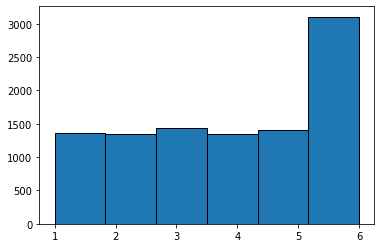

In [6]:
_ = plt.hist(sequence, bins=6, edgecolor='black')

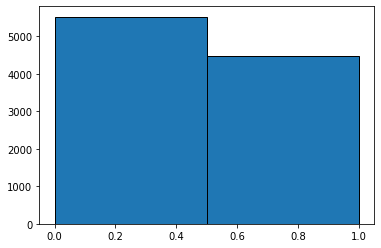

In [7]:
_ = plt.hist(targets, bins=2, edgecolor='black')

<BarContainer object of 10000 artists>

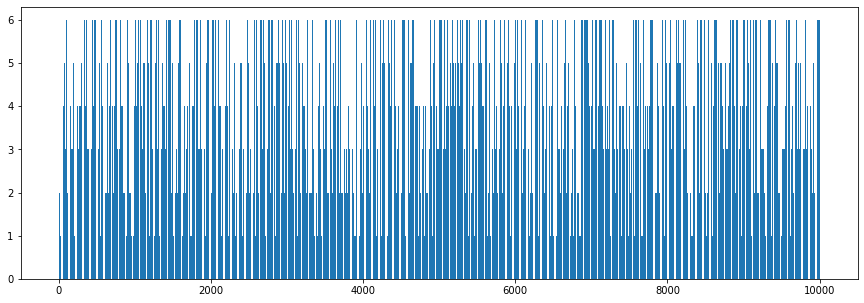

In [8]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence)

## Evaluate heuristic model

In [9]:
sequence, targets = generate_sequence()

In [10]:
preds = heuristic_model(
    sequence, 
    possible_length=1,
    close_gaps=10
)

In [11]:
print(f'Accuracy: {(preds == targets).mean() * 100 :.2f}%', )

Accuracy: 77.53%


Text(0.5, 1.0, 'Real')

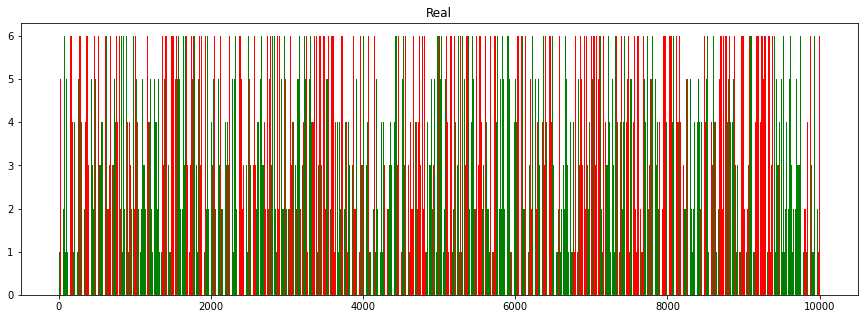

In [12]:
colors = np.array(['g', 'r'])[targets]
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence, color=colors)
plt.title('Real')

Text(0.5, 1.0, 'Predicted')

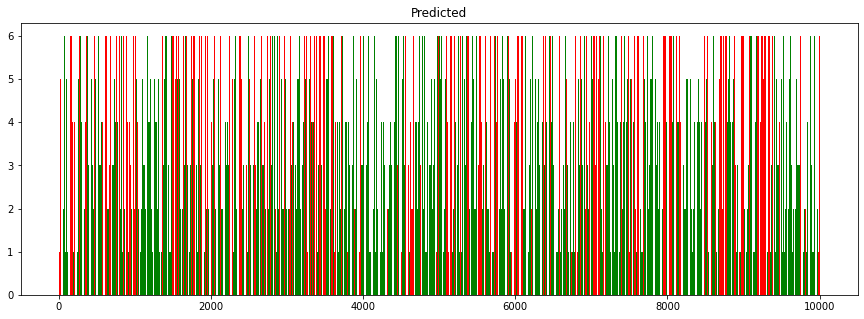

In [13]:
colors = np.array(['g', 'r'])[preds]
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence, color=colors)
plt.title('Predicted')

## Alphas

In [14]:
# 0 - fair dice
# 1 - loaded dice

A = [
    [(1 - p0), p0],
    [p1, (1 - p1)],
]

B = [
    [1 / 6] * 6, [loaded_rest] * 5 + [loaded_6]
]

In [15]:
# baseline
(np.zeros_like(targets) == targets).mean()

0.5489

In [16]:
alpha = [[], []]
alpha[0].append(1)
alpha[1].append(0)

for t, v in enumerate(sequence[:-1]):
    alpha0, alpha1 = 0, 0
    for i in range(2):
        alpha0 += alpha[i][t] * A[i][0] * B[0][v - 1]
        alpha1 += alpha[i][t] * A[i][1] * B[1][v - 1]
    
    alpha[0].append(alpha0 * 5.5)
    alpha[1].append(alpha1 * 5.5)

In [17]:
(np.array(alpha).argmax(axis=0) == targets).mean()

0.7498

Text(0.5, 1.0, 'Predicted')

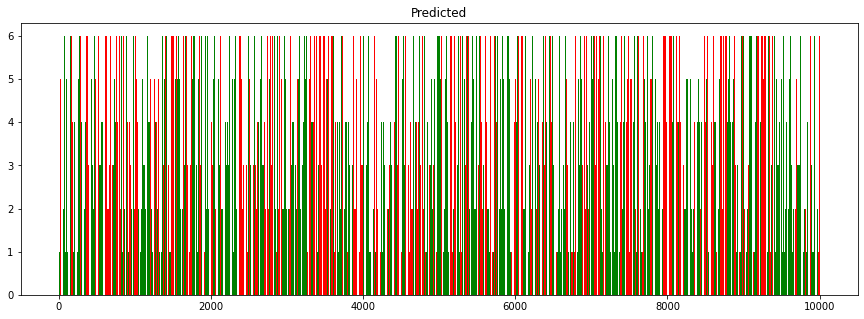

In [18]:
colors = np.array(['g', 'r'])[np.array(alpha).argmax(axis=0)]
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence, color=colors)
plt.title('Predicted')

## Alphas + Betas

In [19]:
sequence = np.array(sequence, dtype=np.int64)

In [20]:
A = np.array(A)
B = np.array(B)
    
alphas = np.zeros((2, len(sequence)))
betas = np.zeros((2, len(sequence)))
    
alphas[0, 0] = 1
alphas[1, 0] = 0

for i in range(1, len(sequence)):
    v = sequence[i]
    for j in range(2):
        for k in range(2):
            alphas[j, i] += alphas[k, i-1] * A[k, j] * B[k, v - 1]
        alphas[j, i] *= 5.5

betas[:, len(sequence) - 1] = 1

for i in reversed(range(len(sequence) - 1)):
    v = sequence[i]
    for j in range(2):
        for k in range(2):
            betas[j, i] += betas[k, i+1] * A[j, k] * B[k, v - 1]
        betas[j,i] *= 5.5

gammas = alphas * betas / np.sum(alphas * betas, axis=0)

print(f'Accuracy: {(np.array(gammas).argmax(axis=0) == targets).mean() * 100}%')

Accuracy: 83.08%


Text(0.5, 1.0, 'Predicted')

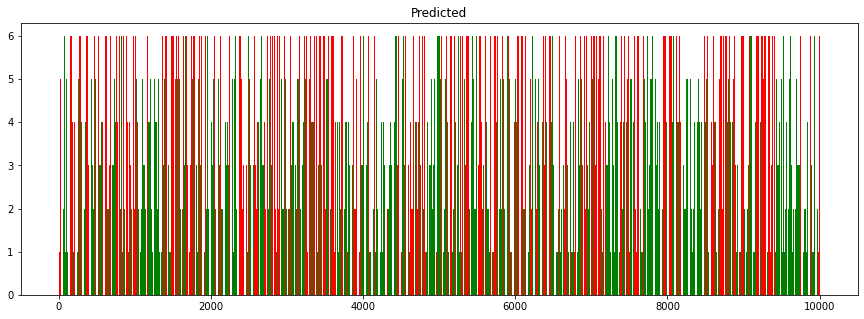

In [21]:
colors = np.array(['g', 'r'])[np.array(gammas).argmax(axis=0)]
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence, color=colors)
plt.title('Predicted')

Text(0.5, 1.0, 'Real')

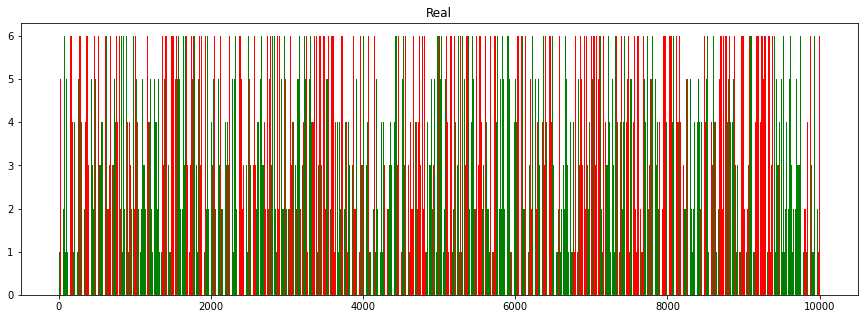

In [22]:
colors = np.array(['g', 'r'])[targets]
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence, color=colors)
plt.title('Real')

## Viterbi

In [23]:
delta = [[], []]
delta[0].append(1)
delta[1].append(0)

for t, v in enumerate(sequence[:-1]):
    delta0, delta1 = 0, 0
    for i in range(2):
        delta0 = max(delta0, delta[i][t] * A[i][0] * B[0][v - 1])
        delta1 = max(delta1, delta[i][t] * A[i][1] * B[1][v - 1])
    
    delta[0].append(delta0 * 5.5)
    delta[1].append(delta1 * 5.5)

In [24]:
(np.array(delta).argmax(axis=0) == targets).mean()

0.7205

Text(0.5, 1.0, 'Predicted')

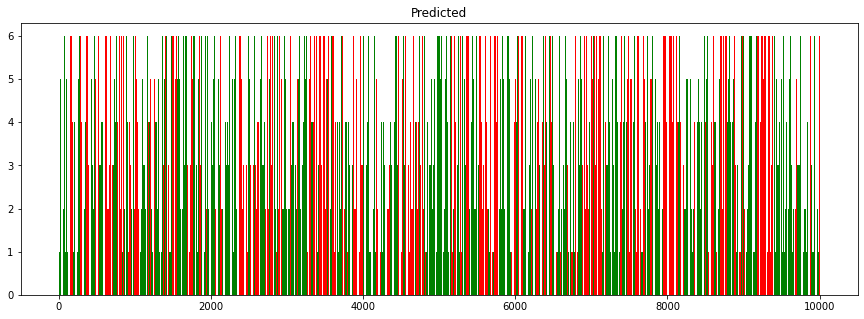

In [25]:
colors = np.array(['g', 'r'])[np.array(delta).argmax(axis=0)]
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence, color=colors)
plt.title('Predicted')

In [26]:
def viterbi(y, A, B, Pi=None):
    """
    Return the MAP estimate of state trajectory of Hidden Markov Model.

    Parameters
    ----------
    y : array (T,)
        Observation state sequence. int dtype.
    A : array (K, K)
        State transition matrix. See HiddenMarkovModel.state_transition  for
        details.
    B : array (K, M)
        Emission matrix. See HiddenMarkovModel.emission for details.
    Pi: optional, (K,)
        Initial state probabilities: Pi[i] is the probability x[0] == i. If
        None, uniform initial distribution is assumed (Pi[:] == 1/K).

    Returns
    -------
    x : array (T,)
        Maximum a posteriori probability estimate of hidden state trajectory,
        conditioned on observation sequence y under the model parameters A, B,
        Pi.
    T1: array (K, T)
        the probability of the most likely path so far
    T2: array (K, T)
        the x_j-1 of the most likely path so far
    """
    # Cardinality of the state space
    K = A.shape[0]
    # Initialize the priors with default (uniform dist) if not given by caller
    Pi = Pi if Pi is not None else np.full(K, 1 / K)
    T = len(y)
    T1 = np.empty((K, T), 'd')
    T2 = np.empty((K, T), 'B')

    # Initilaize the tracking tables from first observation
    T1[:, 0] = Pi * B[:, y[0]]
    T2[:, 0] = 0

    # Iterate throught the observations updating the tracking tables
    for i in range(1, T):
        T1[:, i] = np.max(T1[:, i - 1] * A.T * B[np.newaxis, :, y[i]].T, 1)
        T2[:, i] = np.argmax(T1[:, i - 1] * A.T, 1)

    # Build the output, optimal model trajectory
    x = np.empty(T, 'B')
    x[-1] = np.argmax(T1[:, T - 1])
    for i in reversed(range(1, T)):
        x[i - 1] = T2[x[i], i]

    return x, T1, T2

In [27]:
x, T1, T2 = viterbi(
    y=sequence - 1,
    A=np.array(A),
    B=np.array(B),
    Pi=np.array([1, 0])
)

In [28]:
(x==targets).mean()

0.5608

Text(0.5, 1.0, 'Predicted')

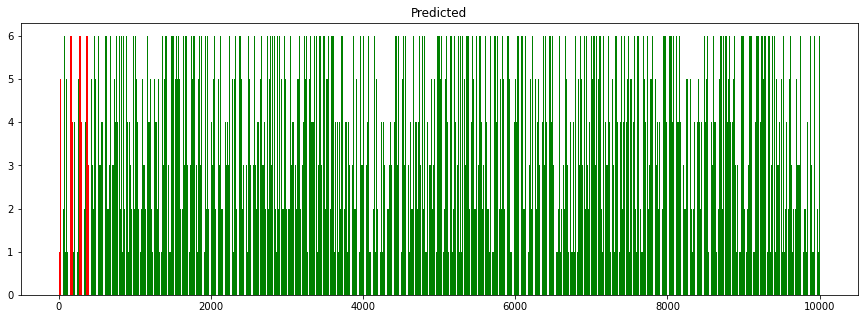

In [29]:
colors = np.array(['g', 'r'])[x]
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence, color=colors)
plt.title('Predicted')

In [30]:
x1, T1, T2 = viterbi(
    y=sequence[:500] - 1,
    A=np.array(A),
    B=np.array(B),
    Pi=np.array([1, 0])
)

In [31]:
x2, T1, T2 = viterbi(
    y=sequence[500:] - 1,
    A=np.array(A),
    B=np.array(B),
    Pi=np.array([1, 0])
)

In [32]:
preds = np.r_[x1, x2]

In [33]:
(preds == targets).mean()

0.5775

Text(0.5, 1.0, 'Predicted')

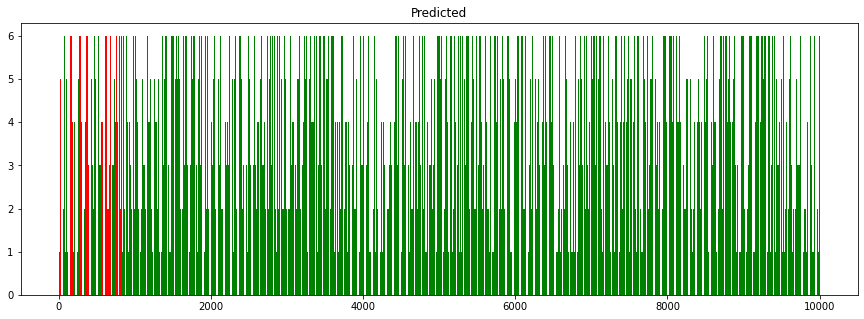

In [34]:
colors = np.array(['g', 'r'])[preds]
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence, color=colors)
plt.title('Predicted')

Text(0.5, 1.0, 'Real')

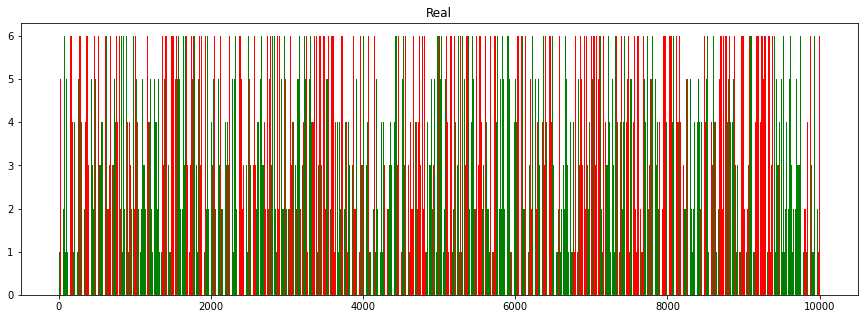

In [35]:
colors = np.array(['g', 'r'])[targets]
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(sequence)), sequence, color=colors)
plt.title('Real')

# Zadanie 4

W tym zadaniu powinieneś zrekonstruować „parametry” krupiera. <br>
Mamy dwie sześcienne kości o nieznanych rozkładach (każdy rozkład to 6 liczb dodatnich, sumujących się do jedynki), zaczynamy od losowo wybranej kości1. <br>
Podobnie jak w poprzednim zadaniu p1 i p2 to prawdopodobieństwa zmiany kości. <br>
Na SKOSIe znajdziesz zestaw 20000 obserwacji (wyników rzutów kością),  <br>
poczynionych dla tego modelu (ale do testów możesz też używać danych wygenerowanych w poprzednim zadaniu).  <br>
Masz zrekonstruować model, uruchom Twój program dla kilku prefiksów dostępnych danych i porównaj wyniki. <br>
<br>
Zastanów się, jak zainicjować model. <br>
Czy rozpoczynanie od równych prawdopodobieństw to dobry pomysł?


In [36]:
data = ""

with open('casino_data.txt') as f:
    for line in f:
        data += line.strip()

In [37]:
data = np.array(list(data), dtype=np.int)

In [38]:
data

array([3, 1, 4, ..., 3, 1, 2])